In [1]:
# Import Libraries
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
# defining a function to quickly read and prepare data
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    df['hour'] = df.lpep_pickup_datetime.dt.hour
    df['dayofweek'] = df.lpep_pickup_datetime.dt.day_of_week

    categorical = ['PULocationID', 'DOLocationID', 'hour', 'dayofweek', 'VendorID']
    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df

In [3]:
# Reading and preparing the dataset
df_train = read_dataframe('/home/ubuntu/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/home/ubuntu/data/green_tripdata_2021-02.parquet')

In [4]:
# Checking the size of datasets
len(df_train), len(df_val)

(73908, 61921)

In [5]:
# defing feature types
categorical = ['PU_DO', 'hour', 'dayofweek', 'VendorID'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# applying one hot encoding
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [6]:
# defining the target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [7]:
# training the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.2402937052289245

In [8]:
# training the Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_val)

mean_squared_error(y_val, lasso_pred, squared=False)

11.06405148247177

In [9]:
# training the Ridge Regression model
rid = Ridge(alpha=0.1)
rid.fit(X_train, y_train)

rig_pred = rid.predict(X_val)

mean_squared_error(y_val, rig_pred, squared=False)

9.67546695234604

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


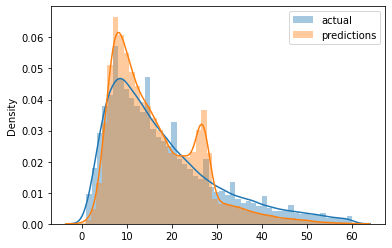

In [10]:
# Plotting actuals vs predictions for top model
sns.distplot(y_val, label = 'actual')
sns.distplot(y_pred, label = 'predictions')

plt.legend()

In [11]:
# Linear regression is the best model
with open('models/lin_reg_v2.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [12]:
# Import Model 1
with open('models/lin_reg.bin', 'rb') as f_in:
    dv_1, model_1 = pickle.load(f_in)

In [13]:
# Function to predict
def predict(data, features, transformer, model):
    trip_info = data.copy().to_dict(orient='records')
    trip_info_transformed = transformer.transform(trip_info)
    predictions = model.predict(trip_info_transformed)
    
    return predictions
    
    

In [14]:
# Model features
model_1_features = ['PU_DO', 'trip_distance']
model_2_features = ['PU_DO', 'trip_distance', 'hour', 'dayofweek', 'VendorID']

model_1_data = df_val[model_1_features]
model_2_data = df_val[model_2_features]

model_1_predictions = predict(model_1_data, model_1_features, dv_1, model_1) 
model_2_predictions = predict(model_2_data, model_2_features, dv, lr) 


In [15]:
# Pring the two predictions from both models
print (model_1_predictions[:2], model_2_predictions[:2], df_val[:2][target].to_list())

[12.77514878 10.49171886] [10.31651404  8.30535436] [17.916666666666668, 6.5]


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

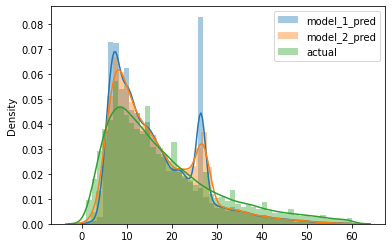

In [16]:
# Plotting the two predictions against actual

sns.distplot(model_1_predictions, label='model_1_pred')
sns.distplot(model_2_predictions, label='model_2_pred')
sns.distplot(y_val, label='actual')

plt.legend()